In [1]:
import numpy as np
import pandas as pd
import math
from tletools import TLE
import time
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import csv
from skyfield.api import load, wgs84
from skyfield.api import EarthSatellite
from skyfield.elementslib import OsculatingElements
from skyfield.data import spice

import matplotlib.pyplot as plt
import matplotlib

import json
import matplotlib.dates as mdates

### No need to run

In [17]:
# 读取TLE数据
tle_file = "../../tle/" + "tle_starlink_3_month_0401_0712.npy"
tle_data = np.load(tle_file, allow_pickle=True)
print("type: ", type(tle_data.item()))
tle_item = tle_data.item()
print("type: ", type(tle_item))
tle = tle_item.items()
d = {}
for k,v in tle:
    d[k] = v # v是多维的，两个月左右的数据，采样粒度可能有区别
print(len(d), d['47150'][0], d['47150'][-1])

# keys (satellites)
keys = [key for key in d.keys()]
print("Number of satellite: ", len(keys))
keys = sorted(keys)

# 判断时间范围
ss = []
for key in keys:
    if d[key][0][0][:10]== '2022-04-01':
        ss.append(key)
# print(set(ss))
keys = ss
print("satellites: ", len(keys))

type:  <class 'dict'>
type:  <class 'dict'>
1701 ['2022-04-01 05:20:18', '1 47150U 20088AE  22091.22243163  .00004265  00000-0  30493-3 0  9991', '2 47150  53.0541 269.1438 0001347  72.7409 287.3727 15.06410475 75421', '6925.316'] ['2022-07-19 13:29:28', '1 47150U 20088AE  22200.56213824  .00002218  00000-0  16775-3 0  9994', '2 47150  53.0546 138.2970 0001607  66.7903 293.3255 15.06404129 91907', '6925.336']
Number of satellite:  1701
satellites:  1686


In [6]:
np.save('keys.npy',keys)

In [3]:
keys = np.load('./data/keys.npy',allow_pickle=True).tolist()

In [6]:
# 读入TLE预测位置信息
cbf_file = "../../tle/" + "pos_cbf_3_month.npy"
pos_file = "../../tle/" + "pos_3_month.npy"

pos_cbf=np.load(cbf_file,allow_pickle=True).tolist()
# print(type(pos_cbf[0][0][0]))
# print(pos_cbf[0][0])
# print(np.shape(pos_cbf))

pos=np.load(pos_file,allow_pickle=True).tolist()
# print(type(pos[0][0][0]))
# print(pos[0][0])
# print(np.shape(pos))

In [18]:
# 统计倾角变化范围
def cal_inclination():
    incs = {}
    for i in range(len(keys)):
        inc = []
        for t,line1,line2,ellipse in d[keys[i]]:
            tle_string = keys[i] + '\n' + line1 + '\n' + line2
            tle_lines = tle_string.strip().splitlines()
            tlee = TLE.from_lines(*tle_lines)
            tmp_inc = round(tlee.inc, 0) # 取整数位
            inc.append(tmp_inc)
        inc = list(set(inc))
        if len(inc) == 1:
            if inc[0] not in incs:
                incs[inc[0]] = [keys[i]]
            else:
                incs[inc[0]].append(keys[i])
        # break
    return incs
sat_inc = cal_inclination()
print("inclination range: ", len(sat_inc), sat_inc.keys())

inclination range:  2 dict_keys([53.0, 70.0])


In [9]:
# 统计高度变化范围
def cal_altitude(key):
    r = []
    sats = sat_inc[key]
    for sat in sats:
        tmp = []
        i = sat
        for lat,lon,alt in pos[i]:
            tmp.append(round(alt,0))
        ranges = [min(tmp), max(tmp)]
        r.append(ranges)
    r = sorted(r, key = lambda x:x[1])
    return r

alts = cal_altitude(53.0)
print(len(alts), alts[0])

1650 [174.0, 250.0]


In [19]:
# 统计不同轨道面卫星分布及变轨情况
file = "../../tle/data/sat_orbits_filtered_3_month.csv"
df = pd.read_csv(file,header=None,sep='\t')
df.drop(labels=None,axis=0, index=0, columns=None, inplace=True)
sat_data = df[0].str.split(',').values.tolist()
print(np.shape(sat_data), sat_data[0])

def save_csv(file, r):
    with open(file,"w") as f: 
        for item in r:
            f.write(item + '\n')

def establish_dict():
    d = {}
    for item in sat_data:
        d[item[-1]] = int(item[0])
    return d
name2orbit = establish_dict()
print(len(name2orbit))

# shell 1
shell_1 = []
for item in sat_data:
    shell_1.append(item[-1])
print("shell_1: ", len(shell_1))

# shell 2
shell_2 = []
for item in sat_inc[53.0]:
    if item not in shell_1:
        shell_2.append(item)
print("shell_2: ", len(shell_2))

# shell 3
shell_3 = [item for item in sat_inc[70.0]]
print("shell_3: ", len(shell_3))

print("total: ", len(shell_1) + len(shell_2) + len(shell_3))

def name_to_shell():
    d = {}
    for sat in shell_1:
        d[sat] = 1
    for sat in shell_2:
        d[sat] = 2
    for sat in shell_3:
        d[sat] = 3
    return d
name2shell = name_to_shell()
print(len(name2shell) == len(keys))
shells = [len(shell_1), len(shell_2), len(shell_3)]

# 保存文件
# save_csv("./data/sat_shell_1.txt", shell_1)
# save_csv("./data/sat_shell_2.txt", shell_2)
# save_csv("./data/sat_shell_3.txt", shell_3)

(1409, 3) ['1', '5', '45182']
1409
shell_1:  1409
shell_2:  241
shell_3:  36
total:  1686
True


In [20]:
np.save('shells.npy',shells)
np.save('name2orbit.npy',name2orbit)

### Start from this line

In [4]:
keys = np.load('../Figure26/data/keys.npy',allow_pickle=True).tolist()
shells = np.load('../Figure26/data/shells.npy',allow_pickle=True).tolist()
name2orbit = np.load('../Figure26/data/name2orbit.npy',allow_pickle=True).item()

In [9]:
shell_1 = list(np.array(pd.read_csv('../Figure26/data/sat_shell_1.txt')).reshape(1408))
shell_2 = list(np.array(pd.read_csv('../Figure26/data/sat_shell_2.txt')).reshape(240))
shell_3 = list(np.array(pd.read_csv('../Figure26/data/sat_shell_3.txt')).reshape(35))

## 变轨相关统计

In [10]:
# 读入变轨卫星信息（所有）
def read_txt(file):
    r = []
    with open(file, "r") as f:  
        line = f.readline()
        while line:
            #if line.strip('\n') in filtered_keys:
            r.append(line.strip('\n'))
            line = f.readline()
    return r
task_maneuver = read_txt("../Figure26/data/task_maneuver.txt")
# task_maneuver = read_txt("./data/maneuver.txt")
print(task_maneuver, len(task_maneuver))

['45568', '45579', '46168', '46326', '46334', '46364', '46671', '46712', '46756', '46757', '46770', '46789', '47138', '47139', '47153', '47372', '47384', '47393', '47394', '47399', '47645', '47646', '47660', '47663', '47666', '47722', '47729', '47732', '47735', '47738', '47768', '47805', '47827', '47836', '47901', '47911', '47913', '47980', '47985', '47995', '47998', '48000', '48002', '48014', '48016', '48018', '48020', '48022', '48028', '48092', '48093', '48112', '48125', '48128', '48135', '48292', '48364', '48368', '48395', '48412', '48432', '48433', '48434', '48458', '48459', '48462', '48481', '48484', '48561', '48575', '48578', '48582', '48594', '48640', '48648', '48666', '48681', '48682', '48684', '48686', '48692'] 81


### No need to run 

In [14]:
# 统计变轨卫星轨道面分布
def cal_maneuver_distribution(mu):
    r = [0, 0, 0]
    for sat in mu:
        shell = name2shell[sat]
        r[shell-1] += 1
    return r
mu_dis = cal_maneuver_distribution(task_maneuver)
print(mu_dis)

[59, 22, 0]


In [15]:
np.save('mu_dis.npy',mu_dis)

### Start from this line

In [11]:
mu_dis = np.load('../Figure26/data/mu_dis.npy',allow_pickle=True).tolist()

### 变轨时长统计

In [18]:
# 读入卫星变轨时间
def read_json():
    file = '../Figure26/data/maneuver_time.json'
    with open(file, 'r') as f:
        data = json.load(f)
    data = json.loads(data)
    print(type(data))
    return data

mu_json = read_json()
print(len(mu_json))

def cal_maneuver_time(data, mu):
    d, r = {}, []
    for key in data:
        if key in mu:
            tmp = data[key]
            for item in tmp:
                start = datetime.datetime.strptime(item[0][:19], '%Y-%m-%d %H:%M:%S')
                stop = datetime.datetime.strptime(item[1][:19], '%Y-%m-%d %H:%M:%S')
                r.append(round(((stop - start).days * 86400 + (stop - start).seconds) / 86400, 2) ) # day
    return r
    
mu_time = cal_maneuver_time(mu_json, task_maneuver)
print(len(mu_time))

<class 'dict'>
273
80


maneuver interval:  8.58 21.49 43.97
8.58 [0.0125 0.0125 0.0125 0.025  0.025  0.025  0.025  0.05   0.05   0.0625]


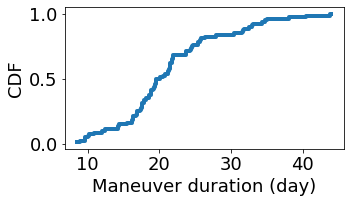

In [19]:
# 绘制时间分布cdf
def plot_mu_time(r):
    print("maneuver interval: ", min(r[0]), np.mean(r[0]), max(r[0]))
    
    # cdf
    fig = plt.figure(figsize=(5, 2.6))
    font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 22,
    }
    ecdf, x, y = [], [], []
    for i in range(len(r)):
        ecdf.append(sm.distributions.ECDF(r[i]))
        x.append(np.linspace(min(r[i]), max(r[i]),num=200))
        y.append(ecdf[i](x[i]))
    
    # colors = ['#000000', '#b30000']
    lines = ['-', '--']
    labels = ['limitless isl (np)', 'limitless isl (p)', '+Grid (np)', '+Grid (p)']

    # right=91.0125
    # plt.xlim(0,right)
    plt.xlabel("Maneuver duration (day)", fontsize = 18)
    plt.ylabel("CDF", fontsize = 18)
    plt.tick_params(labelsize=18)
    
    for i in range(len(r)):
        print(x[i][0], y[i][:10])
        plt.step(x[i], y[i], lines[i], linewidth=4, label=labels[i]) # color=colors[i], 
    
    # plt.plot([x_d[-1],right],[1,1],'--',color=color,linewidth=4)
    # plt.plot([x_h[-1],right],[1,1],'-',color=color,linewidth=4)
      
    # plt.legend(frameon=True, prop=font3, loc=4, labelspacing=0.1)# ,labelspacing=0.1,columnspacing=0.4,ncol=2,loc=3,bbox_to_anchor=(0.032,0.001))  # ,bbox_to_anchor=(0.33,0.82) bbox_to_anchor=(0.73,0.92) bbox_to_anchor=(1.03,0.82)
    plt.savefig("maneuver_time_v1.pdf",dpi=300,bbox_inches = 'tight')
    plt.show()
plot_mu_time([mu_time])

In [20]:
# 根据变轨起始时间，分析变轨同步性
def cal_maneuver_start(data, mu):
    d, r = {}, []
    for key in data:
        if key in mu:
            tmp = data[key]
            for item in tmp:
                # start = datetime.datetime.strptime(item[0][:19], '%Y-%m-%d %H:%M:%S')
                r.append(item[0][:10]) # day
    for item in r:
        if item in d:
            d[item] += 1
        else:
            d[item] = 1
    return r, d

mu_start, mu_d = cal_maneuver_start(mu_json, task_maneuver)
print(mu_start, mu_d)

['2022-05-12', '2022-06-03', '2022-05-18', '2022-05-24', '2022-05-21', '2022-05-10', '2022-05-24', '2022-05-10', '2022-05-18', '2022-05-18', '2022-05-07', '2022-05-28', '2022-05-21', '2022-05-27', '2022-05-28', '2022-05-22', '2022-05-25', '2022-05-18', '2022-06-03', '2022-05-24', '2022-05-24', '2022-05-18', '2022-05-07', '2022-05-18', '2022-05-19', '2022-05-28', '2022-05-19', '2022-05-28', '2022-06-03', '2022-05-21', '2022-05-19', '2022-05-25', '2022-05-10', '2022-05-28', '2022-05-21', '2022-05-27', '2022-05-12', '2022-05-28', '2022-05-28', '2022-05-21', '2022-05-27', '2022-05-10', '2022-05-21', '2022-05-27', '2022-05-28', '2022-05-19', '2022-05-19', '2022-05-18', '2022-05-21', '2022-05-27', '2022-06-02', '2022-05-25', '2022-05-25', '2022-06-04', '2022-05-26', '2022-05-21', '2022-05-21', '2022-05-06', '2022-05-19', '2022-05-18', '2022-05-10', '2022-05-06', '2022-05-18', '2022-05-18', '2022-05-22', '2022-05-05', '2022-05-07', '2022-05-24', '2022-05-21', '2022-05-07', '2022-05-21', '2022

In [21]:
# 生成时间序列数组
def generate_time_series(start, end):
    current = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    end_item = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    time_delta = datetime.timedelta(seconds=86400) # modify
    time_series = [current]
    while current < end_item:
        next = current + time_delta
        time_series.append(next)
        current = next
    return time_series

In [24]:
a = datetime.datetime.strptime("2022-4-1 0:0:0", '%Y-%m-%d %H:%M:%S')
b = datetime.datetime.strptime("2022-4-1 0:0:1", '%Y-%m-%d %H:%M:%S')
print((a-b).days)

-1


In [22]:
# 统计每天变轨的卫星数
def cal_maneuver_day(data, mu):
    time_scale = generate_time_series("2022-4-1 0:0:0", "2022-7-19 23:59:59")[:-1]
    # begin = datetime.datetime.strptime('2022-4-1 0:0:0', '%Y-%m-%d %H:%M:%S')
    r = [0] * len(time_scale)
    for key in data:
        if key in mu:
            tmp = data[key]
            for item in tmp:
                left = datetime.datetime.strptime(item[0][:19], '%Y-%m-%d %H:%M:%S')
                right = datetime.datetime.strptime(item[1][:19], '%Y-%m-%d %H:%M:%S')
                for i in range(len(time_scale)):
                    if left <= time_scale[i] <= right:
                        r[i] += 1
                    
    return r

mu_day = cal_maneuver_day(mu_json, task_maneuver)
print(len(mu_day), mu_day)

110 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 9, 9, 9, 14, 15, 17, 17, 16, 16, 16, 16, 26, 32, 32, 45, 47, 47, 53, 57, 57, 61, 67, 65, 64, 63, 61, 64, 67, 67, 65, 63, 60, 59, 57, 55, 50, 46, 32, 23, 17, 15, 15, 15, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


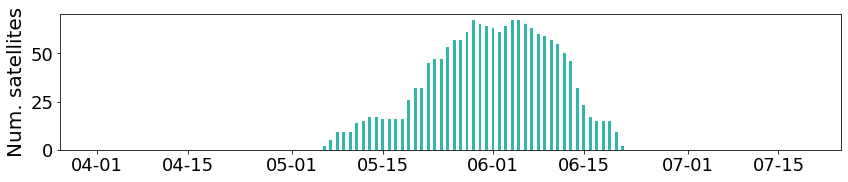

In [23]:
# 绘制每天变轨的卫星
def plot_maneuver_day():
    fig = plt.figure(figsize=(14, 2.5))
    ax = fig.add_subplot(1,1,1)
    font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 18,
    }
    colors = ["#00A491","#FFCD43","#FF592D","#3787C0"]
#     keys = [key for key in mu_d]
#     keys.sort()
#     label_list = [key for key in keys]
    labels = ['without maneuver', 'with maneuver']
    num_list1 = mu_day
    x = generate_time_series("2022-4-1 0:0:0", "2022-7-19 23:59:59")[:-1]
    rects1 = plt.bar(x, height=num_list1, width=0.45, color=colors[0], alpha=0.8, label=labels[0])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    # plt.ylim(0, 1500)
    plt.ylabel("Num. satellites",fontsize=20)
    #plt.xticks(rotation=15)
    #plt.xlabel("Time",fontsize=18)
    plt.tick_params(labelsize=18)
    # plt.legend(prop=font2)
    plt.savefig("maneuver_day_v2.pdf",dpi=300,bbox_inches = 'tight')
    plt.show()
plot_maneuver_day()